В этом ноутбуке я опишу процесс колоризации изображений, используя autoencoder-like сверточную сеть.

Для начала импортируем все библиотеки, которые понадобятся при работе.

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

Будем использовать датасет с примерно 1000 картинок животных, которые можно взять на kaggle. На самом деле не важно какой именно датасет использовать, чем он разнообразнее, тем лучше.

Загрузим данные.

In [2]:
!wget https://www.dropbox.com/s/x6xisyjp63btw2q/animal_pictures.rar
!unrar e animal_pictures.rar /content/train/

--2020-11-19 20:01:10--  https://www.dropbox.com/s/x6xisyjp63btw2q/animal_pictures.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x6xisyjp63btw2q/animal_pictures.rar [following]
--2020-11-19 20:01:10--  https://www.dropbox.com/s/raw/x6xisyjp63btw2q/animal_pictures.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce55c1748c07655d094447ff356.dl.dropboxusercontent.com/cd/0/inline/BDiC69c8uTgMIBmOKUY17o4RpfJMzwrWcu00vj8cApR2VH-0FdSqljIPIU-jakRFo_3JGGdBz6xmia2QIAS4oqzGq5plV7CU2cVNo7qUf0Q9BLLWf5-IzPzJpOUWOgkTHaU/file# [following]
--2020-11-19 20:01:10--  https://uce55c1748c07655d094447ff356.dl.dropboxusercontent.com/cd/0/inline/BDiC69c8uTgMIBmOKUY17o4RpfJMzwrWcu00vj8cApR2VH-0FdSqljIPIU-jakRFo_3JGGdBz6xmia2QIAS4oqzGq5

Создадим вспомогательный класс ColorizationDataset, который реализует взаимодействие с данными. Так как картинок не так много, можно сразу же их загрузить и сохранить в массив.

In [3]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpeg'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            with Image.open(filename) as image:
                self.images.append(image.copy())
      
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

Опишем функцию перевода изображения в черно-белое, а также трансформации, которые мы будем производить с картинками, перед их использованием. Для тестовых и валидационных данных используем разные трансформеры. Различие лишь в том, что к последним мы не будем применять случайный поворот. Сделаем так исключительно для удобства просмотра результатов.

In [4]:
train_transformer = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ToTensor(),
])

val_transformer = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

def to_grayscale(x):
    return (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)

Создадим DataLoader'ы для тестовых и валидационных данных. Хоть мы и выбираем их из одного набора картинок, преобразования transformer'ов будут различны и мы получим различные датасеты.

In [5]:
train_dataset = ColorizationDataset('train', to_grayscale, train_transformer)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = ColorizationDataset('train', to_grayscale, val_transformer)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

100%|██████████| 372/372 [00:00<00:00, 844.37it/s]


Архитектура используемой нейронной сети состоит из повтояющихся блоков, поэтому целесообразно вынести их в отдельные функции:

1. DownBlock уменьшает размерность исходной картинки, увеличивая при этом число ее каналов.
1. UpBlock увеличивает размерность картинки, уменьшая число ее каналов.

In [6]:
def DownBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d((2, 2), stride=(2, 2)),
        nn.LeakyReLU(),
    )

def UpBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(),
    )

Представим, что мы работаем в цветовом пространстве CIELAB и наша исходная картинка имеет только канал L* (Lightness), который отвечает за яркость пикселя. Таким образом, необходимо научить нейросеть восстанавливать значения каналов a* и b*.  

1. На этапе preconcat мы хотим предсказать значение пикселей в каналах a* и b*.
1. На этапе postconcat мы соединим изначальный Lightness канал с результатами работы preconcat и используем подсеть из двух слоев для формирования привычного нам RGB изображения.

Таким представлением данных мы позволяем нашей модели сконцентрироваться на выборе подходящего цвета, а не яркости пикселя, знания о которой модель напрямую получает в postconcat.

In [7]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()

        self.preconcat = nn.Sequential(
            DownBlock(1, 32),
            DownBlock(32, 64),
            DownBlock(64, 128),
            DownBlock(128, 256),

            UpBlock(256, 256),
            UpBlock(256, 256),
            UpBlock(256, 128),
            UpBlock(128, 64)
        )

        self.postconcat = nn.Sequential(
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.preconcat(x)
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

Все вычисления будут производится на GPU, в качестве оптимизатора будем использовать Adam, в  качестве лосса -- MSE.

In [8]:
device = torch.device('cuda:0')

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

При выводе изображений, первым делом нужно их преобразовать в подходящий массив:
1. Это должен быть numpy-массив.
1. Размерность, отвечающая за количество каналов, должна быть последней.

Так как torch работает с данными в немного другом виде, опишем вспомогательную функцию, переводящую одно представление в другое.

In [9]:
def convert(x):
    return x.transpose(0, 1).transpose(1, 2).cpu().detach().numpy()

Опишем функцию, которая будет выводить картинки и лосс на каждой эпохе.

In [10]:
def print_statistics(val_loss, train_loss, num_epoch, colorized_picture, true_picture):
    f, ax = plt.subplots()
    ax.set_title("Loss on iter {}:".format(num_epoch))
    ax.plot(val_loss, label='validation loss')
    ax.plot(train_loss, label='train loss')
    ax.legend()
    
    f.set_figwidth(8)
    f.set_figheight(8)
    plt.show()

    f, ax = plt.subplots(1, 2)
    f.suptitle('Colorization on iter {}:'.format(num_epoch))
    
    ax[0].set_title('Colorized picture')
    ax[0].imshow(colorized_picture)
    ax[1].set_title('True image')
    ax[1].imshow(true_picture)
    plt.show()

Далее обучим сеть.

Каждые print_iter итераций будем выводить картинку, раскарашенную нейросетью, и оригинал, а так же лоссы по эпохе. Чтобы удобнее отслеживать обучение.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


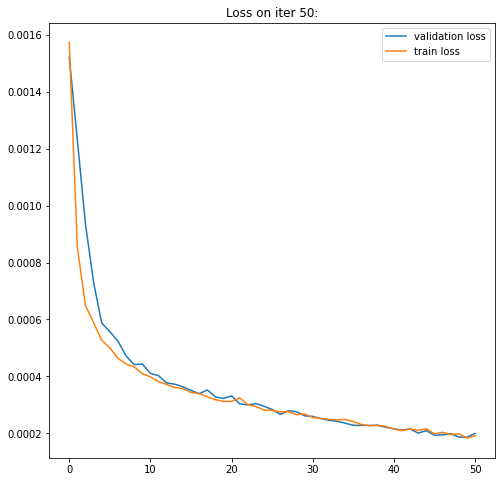

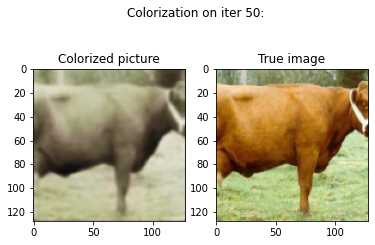

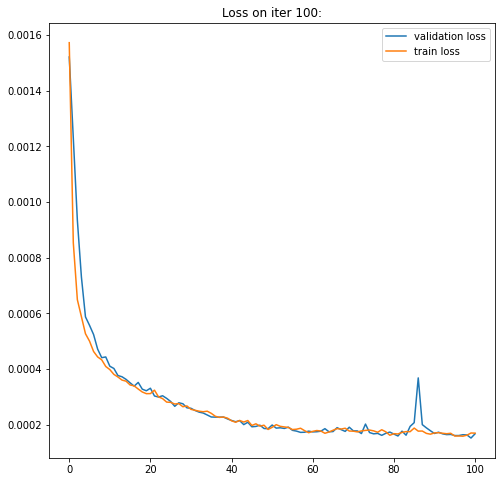

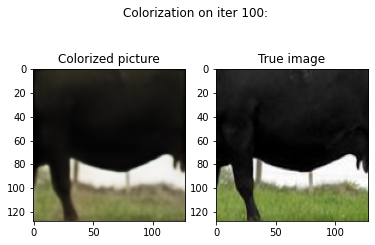

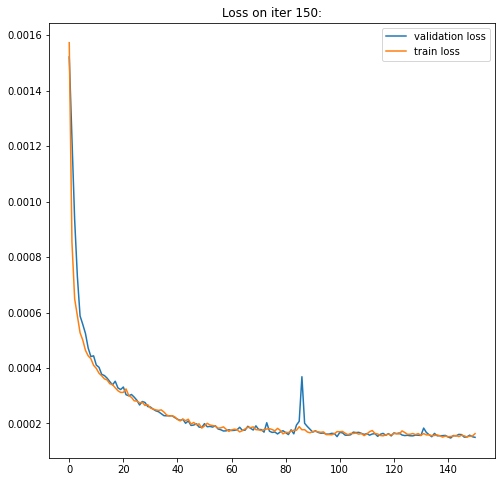

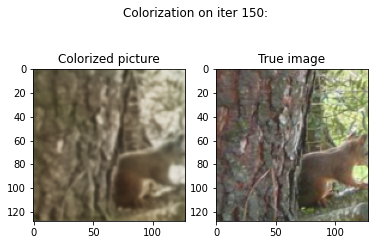

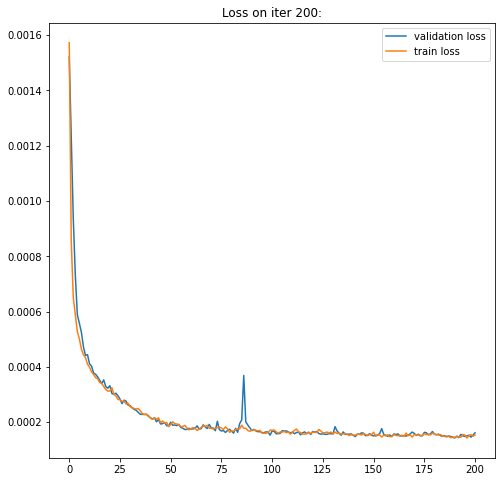

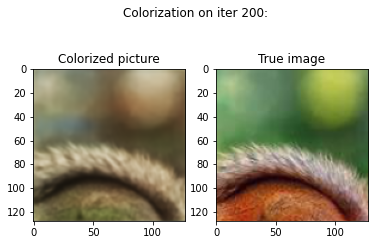

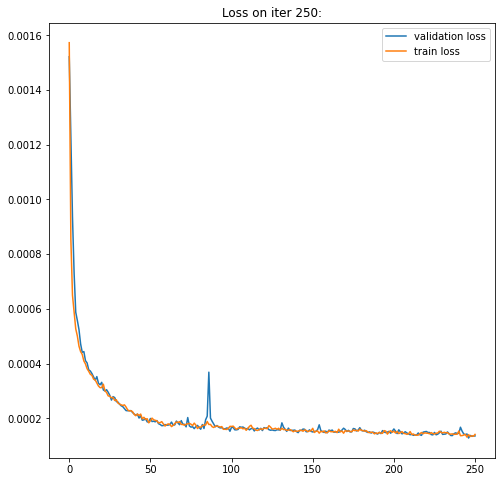

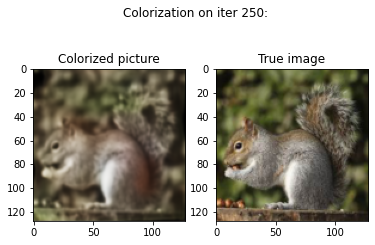

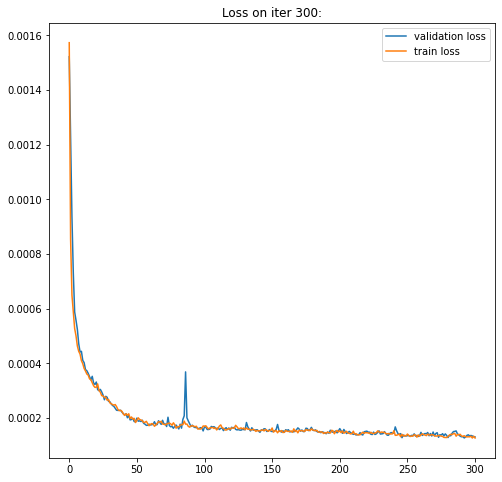

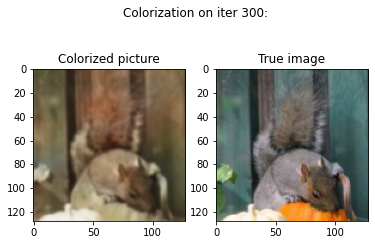

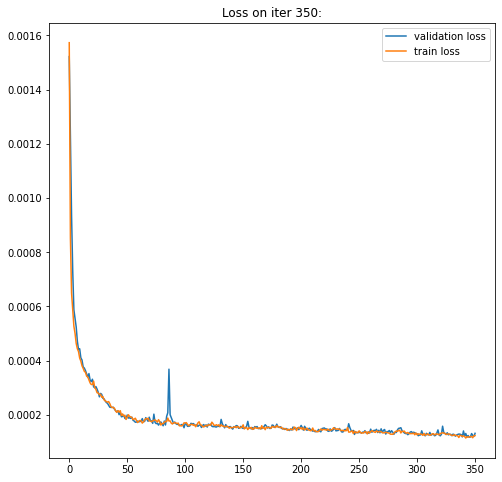

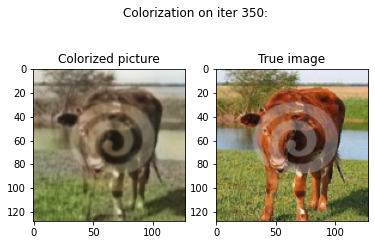

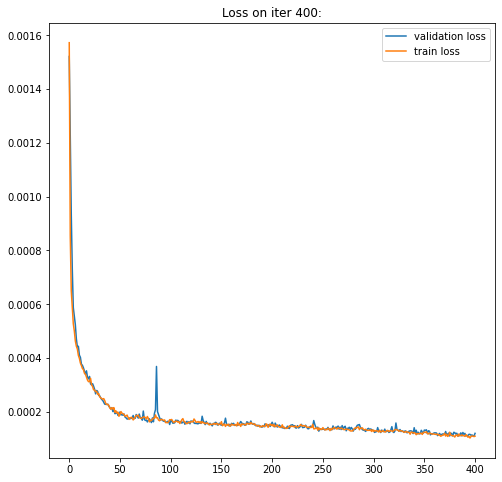

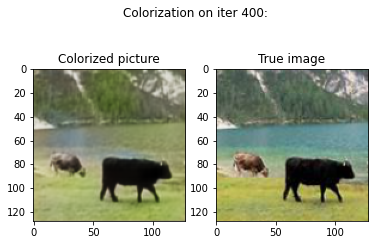

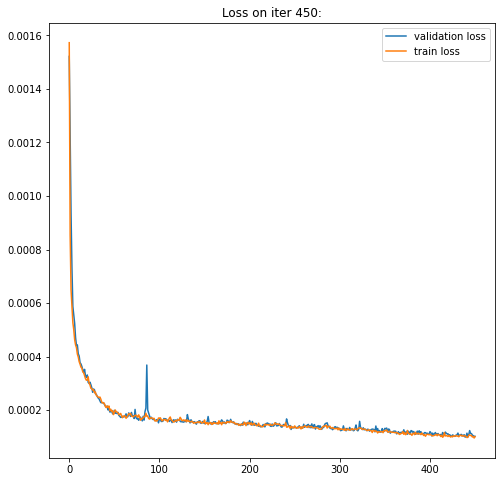

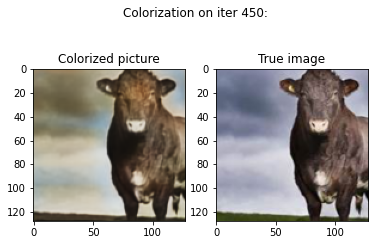

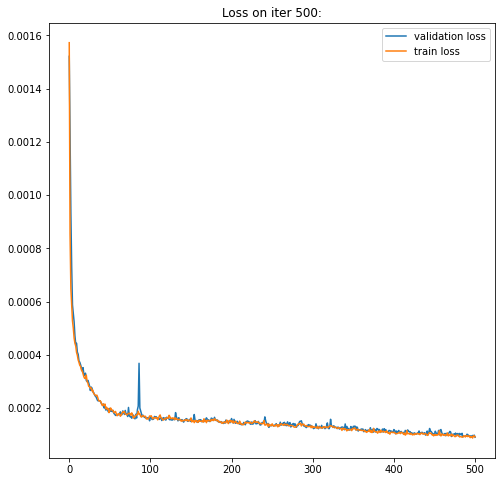

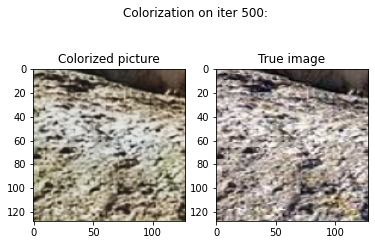

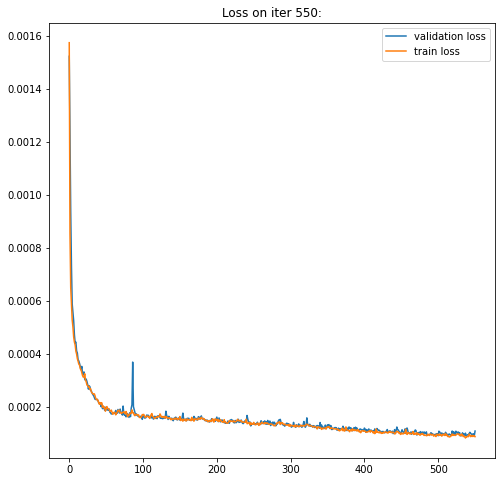

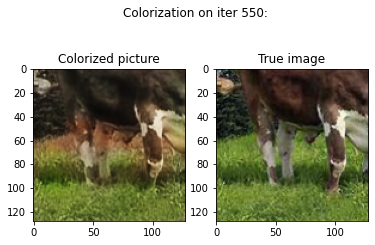

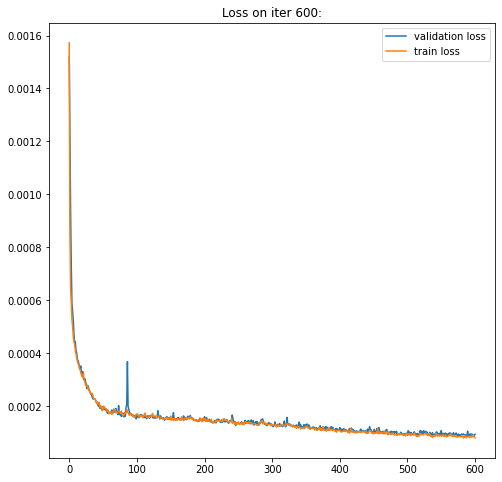

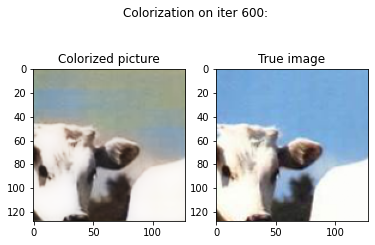

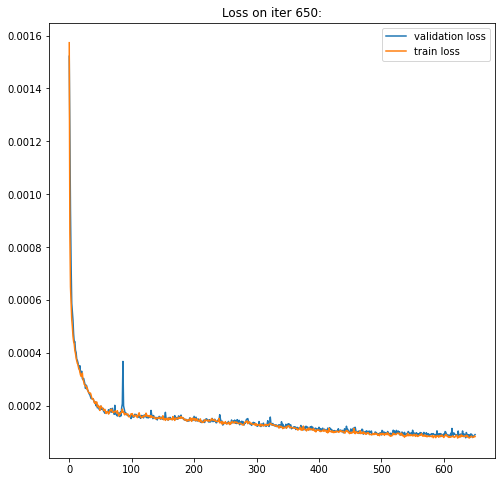

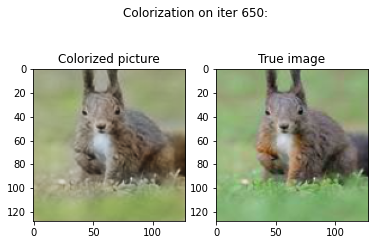

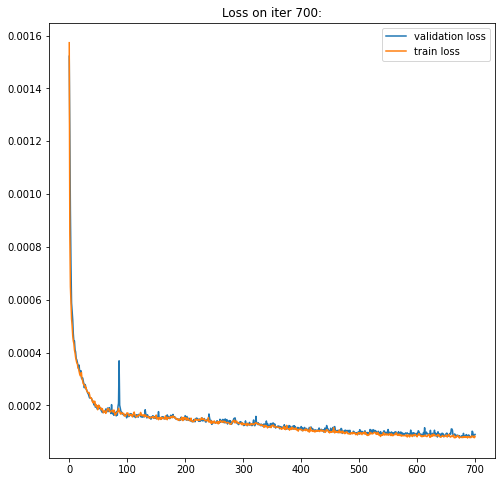

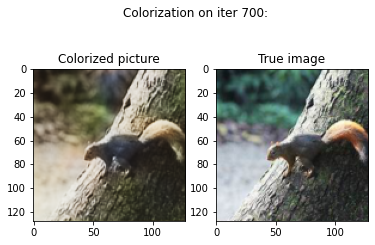

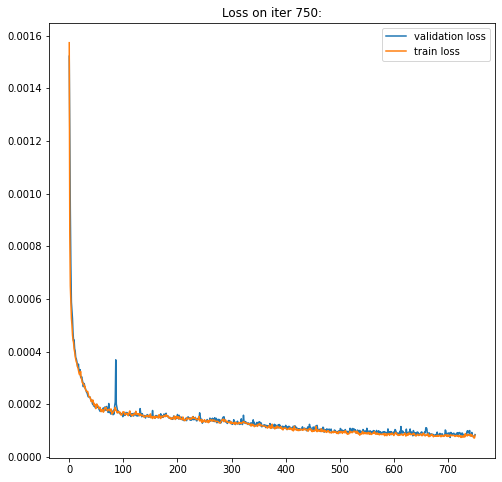

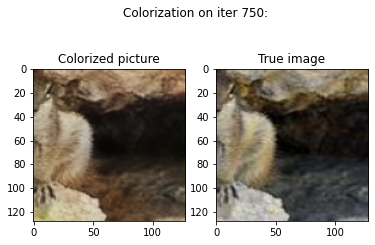

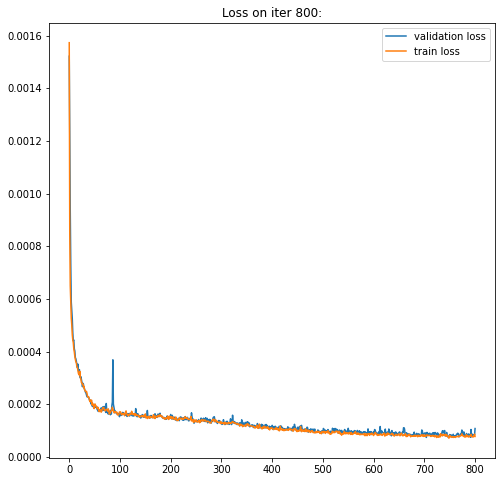

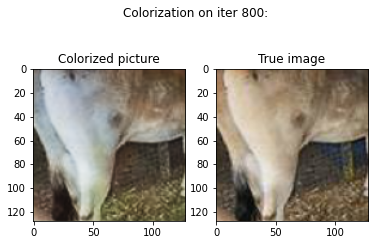

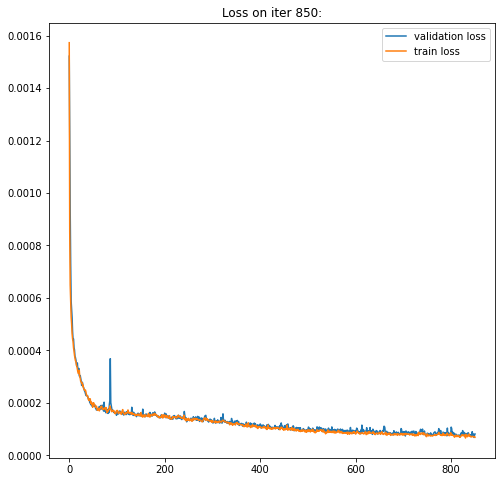

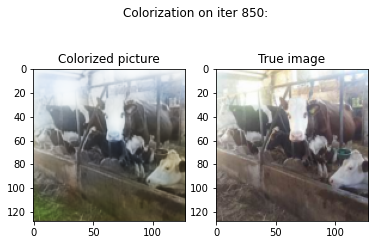

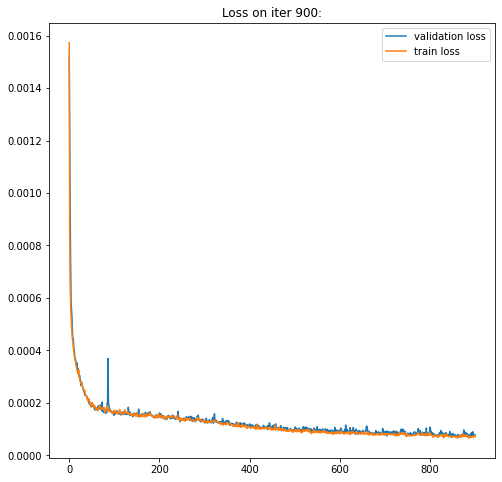

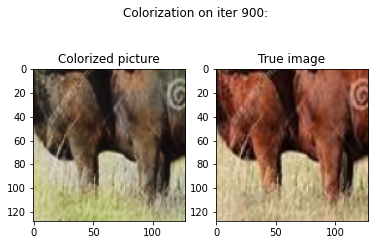

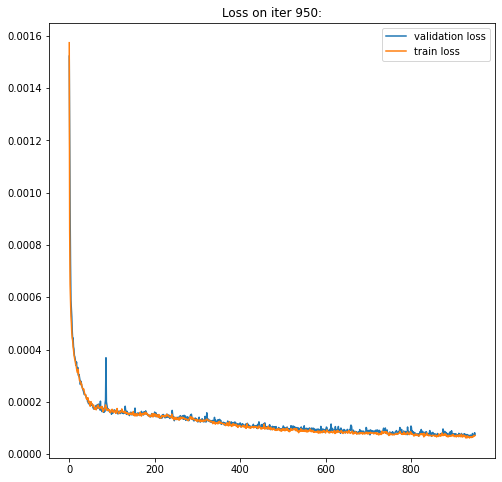

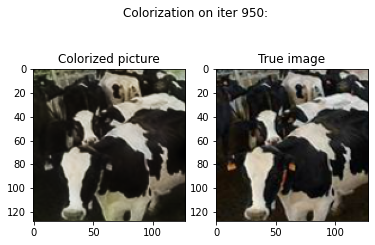

In [11]:
num_epochs = 1000
print_iter = 50
train_history = []
val_history = []

for i in tqdm_notebook(range(num_epochs)):
    train_epoch_loss = 0
    model.train()

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        outp = model(x)
        loss = criterion(outp, y)
        loss.backward()

        train_epoch_loss += loss.item()
        optimizer.step()

        del x
        del y
        torch.cuda.empty_cache()
    
    val_epoch_loss = 0
    model.eval()

    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        outp = model(x)
        loss = criterion(outp, y)
        val_epoch_loss += loss.item()

        if (i > 0) and (i % print_iter == 0):
            tmpx = convert(outp[0])
            tmpy = convert(y[0])
    
        del x
        del y
        torch.cuda.empty_cache()
    

    val_history.append(val_epoch_loss / 128)
    train_history.append(train_epoch_loss / 128)
    if (i > 0) and (i % print_iter == 0):
        print_statistics(val_history, train_history, i, tmpx, tmpy)

Теперь посмотрим на результат работы нашей сети.

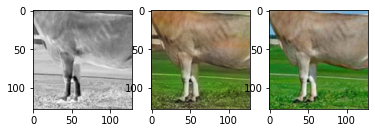

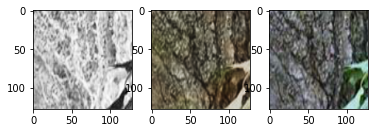

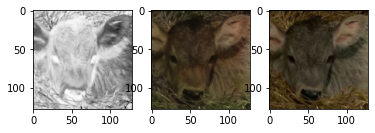

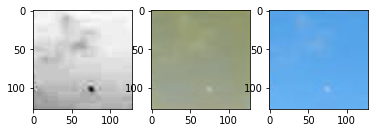

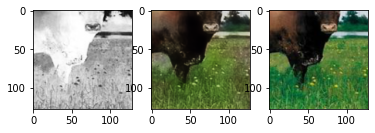

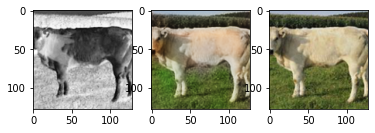

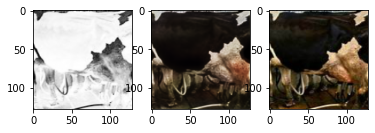

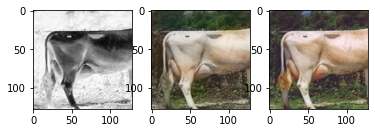

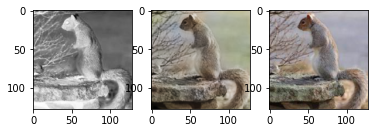

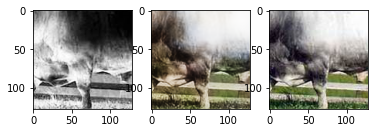

In [16]:
for i in range(10):
    img_gray, img_true = val_dataset[i]
    img_pred = model(img_gray.to(device).reshape(1, 1, 128, 128))

    f, ax = plt.subplots(1, 3)
    ax[0].imshow(img_gray.reshape(128, 128), cmap='Greys')
    ax[1].imshow(convert(img_pred.reshape(3, 128, 128)))
    ax[2].imshow(convert(img_true))
    plt.show()

Как можем видеть, нейросеть справилась с задачей довольно хорошо. Конечно большее число итераций обучения, больший размер датасета и его "разнообразность" помогли бы увеличить качество колоризации. 

Сохраним полученную модель.

In [19]:
torch.save(model, '/content/colorizer.pt')

Ссылка на данную модель: https://www.dropbox.com/s/svvrc9x2l55wvya/colorizer_save.pt

С помощью кода ниже можно загрузить данную модель на свой компьютер. 

Обратите внимание, что у вас должна быть доступна возможность использования видеокарты, а так же описан класс Colorizer.

In [ ]:
!wget https://www.dropbox.com/s/svvrc9x2l55wvya/colorizer_save.pt
model = torch.load('colorizer_save.pt')
model.eval()